# **Text Mining** - Projeto Final

## Trabalho realizado por:
-  Beatriz Lopes - nº 120627
-  Francisco Pereira - nº 99814
-  Joana Almeida - nº 121157


## **Importação das Bibliotecas necessárias para o desenvolvimento do projeto -**

In [198]:
#!pip install scikit-learn
#!pip install pandas numpy seaborn matplotlib nltk spacy gensim torch textblob scikit-learn imbalanced-learn transformers

In [199]:
import re
import string
import nltk
import spacy

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import gensim.downloader as api
import gensim
import torch
import torch.nn.functional as F
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from textblob            import TextBlob

from sklearn                         import metrics
from sklearn.utils                   import shuffle
from sklearn.svm                     import SVC
from sklearn.metrics                 import classification_report
from sklearn.naive_bayes             import MultinomialNB, GaussianNB
from sklearn.linear_model            import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection         import train_test_split

from nltk.corpus         import stopwords
from nltk.stem           import WordNetLemmatizer
from nltk.tokenize       import word_tokenize
from nltk.stem.snowball  import SnowballStemmer
from nltk.sentiment.util import mark_negation

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import SMOTE

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

from tensorflow.keras.layers           import Input, Dropout, Dense
from tensorflow.keras.models           import Model
from tensorflow.keras.optimizers       import Adam
from tensorflow.keras.callbacks        import EarlyStopping
from tensorflow.keras.initializers     import TruncatedNormal
from tensorflow.keras.losses           import CategoricalCrossentropy
from tensorflow.keras.metrics          import CategoricalAccuracy
from tensorflow.keras.utils            import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **1.1 Dados**

<br>

## **Análise dos Dados de Treino -**

In [200]:
# Ler os dados de treino do Rotten Tomatoes
file_path = 'rotten_tomatoes_train.tsv'
training_data = pd.read_csv(file_path, sep='\t', header=None)

In [201]:
# 5 entradas do dataset
training_data.head()

,0,1,2
0,3088,positive,Foster and Whitaker are especially fine .
1,6509,positive,It 's the brilliant surfing photography bringi...
2,3022,positive,Spare but quietly effective retelling .
3,3707,positive,-LRB- Leigh -RRB- has a true talent for drawin...
4,4785,positive,Boasts enough funny dialogue and sharp charact...


In [202]:
# Atribuir nomes às colunas
training_data.columns = ['Id', 'Sentiment', 'Review']

In [203]:
# Atribuir os data types corretos aos dados
training_data['Id'] = training_data['Id'].astype(int)
training_data['Sentiment'] = training_data['Sentiment'].astype(str)
training_data['Review'] = training_data['Review'].astype(str)

In [204]:
# Info do dataset
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         6800 non-null   int64 
 1   Sentiment  6800 non-null   object
 2   Review     6800 non-null   object
dtypes: int64(1), object(2)
memory usage: 159.5+ KB


In [205]:
# Ver a quantidade de entradas nulas do dataset
training_data.isnull().sum()

# Não foram identificados valores nulos em nenhuma das classes

Id           0
Sentiment    0
Review       0
dtype: int64

Sentiment
positive    2888
negative    2601
neutral     1311
Name: count, dtype: int64


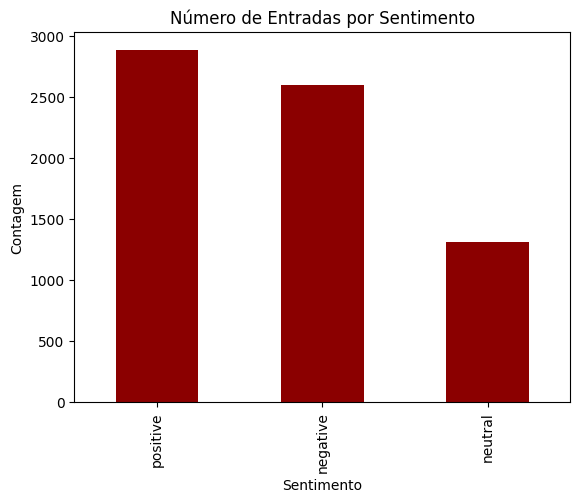

In [206]:
# Contar o número de entradas de cada tipo de sentiment
sentiment_counts = training_data['Sentiment'].value_counts()
print(sentiment_counts)

# Criar o gráfico de barras
sentiment_counts.plot(kind='bar', color='darkred')
# Adicionar título e rótulos dos eixos
plt.title('Número de Entradas por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()

# Neste gráfico é possível verificar que as classes não se encontram balanceadas

In [207]:
# Contar o número de caracteres de cada Review
training_data['text_length'] = training_data['Review'].apply(len)

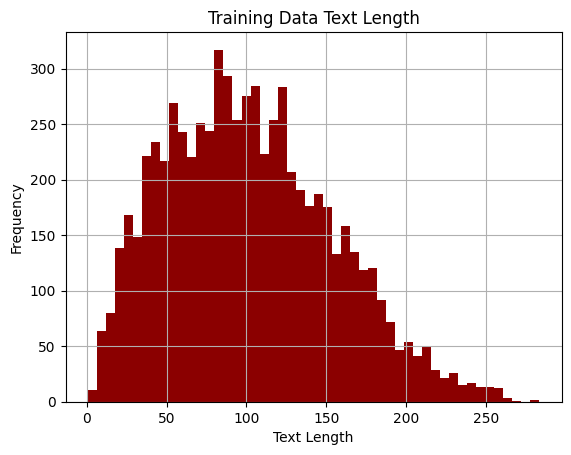

In [208]:
# Plot com a distribuição do número de caracteres de cada Review
training_data['text_length'].hist(bins=50, color='darkred')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Training Data Text Length')
plt.show()

# O histograma indica que os comprimentos da maioria das reviews nos dados de treino têm menos de 150 palavras

In [209]:
# Calcular a média do comprimento das reviews
average_length = training_data['text_length'].mean()
print(f"A média do comprimento das reviews é: {average_length}")

A média do comprimento das reviews é: 101.82882352941176


<br>

## **Análise dos Dados de Teste -**

In [210]:
# Ler os dados de teste do Rotten Tomatoes
file_path = 'rotten_tomatoes_test.tsv'
test_data = pd.read_csv(file_path, sep='\t', header=None)

In [211]:
# 5 entradas do dataset
test_data.head()

,0,1,2
0,3230,negative,With a tighter editorial process and firmer di...
1,4659,positive,If ever a concept came handed down from the mo...
2,7019,negative,Whether Jason X is this bad on purpose is neve...
3,3258,positive,Alternates between deadpan comedy and heartbre...
4,6978,neutral,"God is great , the movie 's not ."


In [212]:
# Atribuir nomes às colunas
test_data.columns = ['Id', 'Sentiment', 'Review']

In [213]:
# Atribuir os data types corretos aos dados
test_data['Id'] = test_data['Id'].astype(int)
test_data['Sentiment'] = test_data['Sentiment'].astype(str)
test_data['Review'] = test_data['Review'].astype(str)

In [214]:
# Info do dataset
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         1729 non-null   int64 
 1   Sentiment  1729 non-null   object
 2   Review     1729 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.6+ KB


In [215]:
# Ver a quantidade de entradas nulas do dataset
test_data.isnull().sum()

# Não foram identificados valores nulos em nenhuma das classes

Id           0
Sentiment    0
Review       0
dtype: int64

In [216]:
# Contar o número de entradas de cada tipo de sentiment
sentiment_counts = test_data['Sentiment'].value_counts()
print(sentiment_counts)

# Podemos observar, tal como nos dados de treino, um desequilíbrio nas classes.
# As classes "positive" e "negative" possuem um número significativamente maior de entradas em comparação com a classe "neutral".

Sentiment
positive    714
negative    671
neutral     344
Name: count, dtype: int64


In [217]:
# Contar o número de caracteres de cada Review
test_data['text_length'] = test_data['Review'].apply(len)

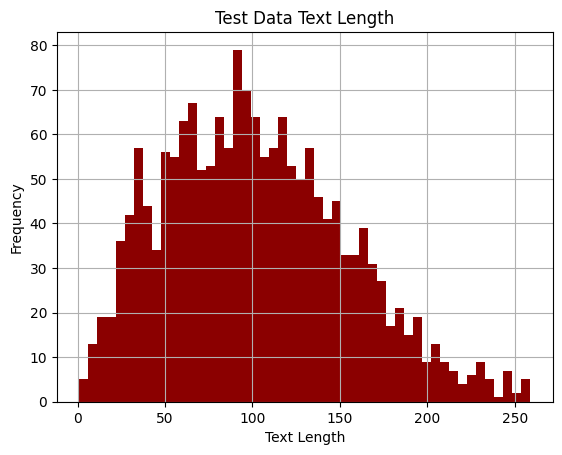

In [218]:
# Plot com a distribuição do número de caractéres de cada Review
test_data['text_length'].hist(bins=50, color='darkred')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Test Data Text Length')
plt.show()

# Face ao histograma referente aos dados de treino, este demonstra uma distribuição significativamente mais uniforme.

In [219]:
# Calcular a média do comprimento das reviews
average_length = test_data['text_length'].mean()
print(f"A média do comprimento das Reviews é: {average_length}")

# O comprimento médio das Reviews nos dados de teste está bastante próximo aos dados de treino.

A média do comprimento das Reviews é: 102.04337767495662


<br>

## **Remoção dos Dados classificados como neutros -**

In [220]:
# Após uma análise cuidadosa do contexto do problema e dos dados disponíveis, e tendo em conta o proposto neste projeto, optou-se por não preservar os dados neutros.
# Esta decisão foi tomada devido ao desequilíbrio significativo dos dados e a outras razões detalhadas no relatório.

test_data = test_data[test_data['Sentiment'] != 'neutral']
training_data = training_data[training_data['Sentiment'] != 'neutral']

<br>
<br>
<br>

# **1.2 Definição de uma baseline usando ferramentas já existentes**

## **TextBlob -**

In [ ]:
import spacy
import pandas as pd
from textblob import TextBlob
from textblob import Word
import re
from nltk import bigrams
from nltk.corpus import stopwords

In [ ]:
def classify_sentiment(text):
    # Criar um objeto TextBlob
    blob = TextBlob(text)
    # Obter a pontuação de polaridade
    polarity = blob.sentiment.polarity

    # Classificar o rótulo de sentimento com base apenas na pontuação de polaridade
    if polarity > 0.1:
        return "positive"
    else:
        return "negative"

    return Sentiment_label

In [ ]:
# Aplicar a função classify_sentiment para a coluna 'Review' ao conjunto de teste
test_data['Sentiment_label'] = test_data['Review'].apply(classify_sentiment)

In [ ]:
test_data.head(5)

,Id,Sentiment,Review,text_length,Sentiment_label
0,3230,negative,With a tighter editorial process and firmer di...,221,positive
1,4659,positive,If ever a concept came handed down from the mo...,89,negative
2,7019,negative,Whether Jason X is this bad on purpose is neve...,55,negative
3,3258,positive,Alternates between deadpan comedy and heartbre...,147,negative
6,7102,positive,"This time , the hype is quieter , and while th...",153,positive


In [ ]:
from sklearn.metrics import classification_report

# Suponha que test_data['true_label'] contém as verdadeiras etiquetas de sentimento
true_labels = test_data['Sentiment']
predicted_labels = test_data['Sentiment_label']

# Gerar o classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Alcançou uma accuracy de 68%, o que significa que o modelo classifica corretamente cerca de 68% dos dados de teste.

              precision    recall  f1-score   support

    negative       0.65      0.72      0.68       671
    positive       0.71      0.64      0.67       714

    accuracy                           0.68      1385
   macro avg       0.68      0.68      0.68      1385
weighted avg       0.68      0.68      0.68      1385



<br>
<br>
<br>

# **1.3 Preparação de dados e aplicação de um léxico de sentimentos**

## **Classificador de sentimentos baseado num léxico (sem tratamento da negação) -**

In [221]:
# Importar e ler o léxico NRC através do github do professor
lexname="https://raw.githubusercontent.com/fmmb/Text-Mining/main/data/NRC-lexicon.csv"
lex_data = pd.read_csv(lexname, encoding="utf-8", index_col=["English"])

In [222]:
# 5 primeiras entradas do léxico:
lex_data.head(5)

,Positive,Negative
English,,
aback,0,0
abacus,0,0
abandon,0,1
abandoned,0,1
abandonment,0,1


In [223]:
# Mostrar o tamanho do léxico
print(f"Lexicon Size: {len(lex_data)} words")

Lexicon Size: 14182 words


In [224]:
# Ao subtrair o valor de Positive por Negative obtemos um valor único associado a cada palavra

# Palavra Positiva:  Positive = 1; Negative = 0  ->  1-0  =  1
# Palavra Negativa:  Positive = 0; Negative = 1  ->  0-1  = -1

# Efetuar este cálculo e armazenar as palavras com os seus respetivos valores num dicionário:
lex = (lex_data['Positive']-lex_data['Negative']).to_dict()

In [225]:
# Carregar o modelo do spaCy
nlp = spacy.load("en_core_web_sm")

# Função para calcular o sentimento de um texto usando o spaCy para lematização
def sentiment(text):
    doc = nlp(text)
    sum = 0
    for token in doc:
        # Usar o lema da palavra para melhorar a correspondência no léxico
        sum += lex.get(token.lemma_, 0)
    return "positive" if sum >= 0 else "negative"

In [226]:
# Aplicar a função de sentimento para cada revisão no DataFrame
test_data['Sentiment_label_lexicon'] = test_data['Review'].apply(sentiment)

In [227]:
test_data.head(5)

,Id,Sentiment,Review,text_length,Sentiment_label_lexicon
0,3230,negative,With a tighter editorial process and firmer di...,221,positive
1,4659,positive,If ever a concept came handed down from the mo...,89,positive
2,7019,negative,Whether Jason X is this bad on purpose is neve...,55,negative
3,3258,positive,Alternates between deadpan comedy and heartbre...,147,negative
6,7102,positive,"This time , the hype is quieter , and while th...",153,positive


In [228]:
from sklearn.metrics import classification_report

true_labels = test_data['Sentiment'] # valores verdadeiros de sentimento
predicted_labels = test_data['Sentiment_label_lexicon'] # valores previstos de sentimento

# Gerar o report de classificação
report = classification_report(true_labels, predicted_labels)
print(report)

# Os resultados mostram que o modelo alcançou uma precisão menor do que a atingida com o TextBlob

              precision    recall  f1-score   support

    negative       0.70      0.34      0.45       671
    positive       0.58      0.86      0.69       714

    accuracy                           0.61      1385
   macro avg       0.64      0.60      0.57      1385
weighted avg       0.64      0.61      0.58      1385



## **Pré-processamento -**

In [ ]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()
    # Remover números (opcional)
    text = re.sub(r'\d+', '', text)
    # Expandir contrações
    text = " ".join([Word(word).spellcheck()[0][0] if Word(word).spellcheck()[0][1] < 0.95 else word for word in text.split()])
    # Tokenizar com o SpaCy
    doc = nlp(text)
    # Filtrar tokens (remover stopwords, pontuações e aplicar lematização)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and token.text.isalpha()]
    # Juntar os tokens de volta numa string
    preprocessed_text = " ".join(filtered_tokens)
    return preprocessed_text

In [ ]:
# Aplicar a função de sentimento para cada revisão no DataFrame
test_data['Preprocessed_Review'] = test_data['Review'].apply(preprocess_text)
training_data['Preprocessed_Review'] = training_data['Review'].apply(preprocess_text)

In [ ]:
# Definindo as opções de exibição para mostrar o texto completo no output.
pd.set_option('display.max_colwidth', None)
test_data

## **Classificador de sentimentos baseado num léxico (com tratamento da negação) -**

In [ ]:
# Função que determina se uma palavra é uma negação
def is_negation(token):
    negations = {"not", "n't", "no", "never", "none"}
    return token.lemma_ in negations

In [ ]:
# Modificar a função de sentimento para considerar a negação
def sentiment(text):
    doc = nlp(text)
    sum = 0
    apply_negation = False
    for token in doc:
        if is_negation(token):
            apply_negation = True  # Ativar a negação
        elif token.pos_ == "PUNCT":
            apply_negation = False  # Desativar a negação ao encontrar uma pontuação

        # Obter valor do léxico
        sentiment_value = lex.get(token.lemma_, 0)

        # Inverter o sentimento se a negação estiver ativa
        if apply_negation:
            sentiment_value *= -1

        sum += sentiment_value
    return "positive" if sum >= 0 else "negative"

In [ ]:
# Gerar uma nova coluna com os sentimentos baseados num léxico com tratamento da negação
test_data['Sentiment_label_lexicon_2'] = test_data['Preprocessed_Review'].apply(sentiment)

In [ ]:
from sklearn.metrics import classification_report

true_labels = test_data['Sentiment'] # valores verdadeiros de sentimento
predicted_labels = test_data['Sentiment_label_lexicon_2'] # valores previstos de sentimento

# Gerar o report de classificação
report = classification_report(true_labels, predicted_labels)
print(report)

<br>
<br>
<br>

# **4 - Treino de um modelo (aprendizagem automática)**

## **Técnicas de Balanceamento -**

In [ ]:
def oversampling(x, y):

    smote = SMOTE() # Cria uma instância de SMOTE

    # Aplica SMOTE para realizar o oversampling
    x_resampled, y_resampled  = smote.fit_resample(x, y)

    return x_resampled, y_resampled

In [ ]:
def undersampling(x, y):

    rus = RandomUnderSampler(random_state=42) # Cria uma instância de RandomUnderSampler

    # Aplica RandomUnderSampler para realizar o undersampling
    x_resampled, y_resampled = rus.fit_resample(x, y)

    return x_resampled, y_resampled

## **Técnicas de Vectorização -**

In [ ]:
# Word2vec

def tokenize(Review):
    tokens = word_tokenize(Review)
    return tokens

def get_word_vectors(tokens, model):
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
    return vectors

def get_review_vector(vectors, model):
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

def w2v(x_train, x_test):

    model = api.load('word2vec-google-news-300')

    tokenized_reviews = [tokenize(Review.lower()) for Review in x_train]

    vectors     = [get_word_vectors(tokens, model) for tokens in tokenized_reviews]

    x_train_vec = [get_review_vector(vectors[i], model) for i in range(len(x_train))]
    x_test_vec  = [get_review_vector(vectors[i], model) for i in range(len(x_test))]

    return x_train_vec, x_test_vec

In [ ]:
# Definição da função TF-IDF

def tf_idf(x_train, x_test):
    tfidf_model  = TfidfVectorizer(max_df=0.85)
    x_train_tfidf = tfidf_model.fit_transform(x_train)
    x_test_tfidf  = tfidf_model.transform(x_test)
    return x_train_tfidf, x_test_tfidf

In [ ]:
# Definição da função vectorize

def vectorize(x_train, x_test):

    vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.85)
    x_train_vec = vectorizer.fit_transform(x_train)
    x_test_vec  = vectorizer.transform(x_test)

    return x_train_vec, x_test_vec

## **Treino dos Modelos**

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# Treino do modelo

def train_model(col_name, bd_train, bd_test, model, vec,  bal=False, results=False, conf_matrix=False):

    # Obter os vetores para os textos de treino e teste
    x_train = bd_train[col_name]
    x_test  = bd_test[col_name]

    # Escolher o tipo de vetorização
    if vec == "w2v":
        x_train, x_test = w2v(x_train, x_test)
    elif vec == "vectorize":
        x_train, x_test = vectorize(x_train, x_test)
    elif vec == "tf-idf":
        x_train, x_test = tf_idf(x_train, x_test)
    else:
        raise Exception("Vetorização inválida")

    # Obter as classes
    y_train = bd_train['Sentiment']
    y_test  = bd_test['Sentiment']

    # Balancear os dados
    if bal == "oversampling" :
      x_train, y_train = oversampling(x_train, y_train)
    if bal == "undersampling":
      x_train, y_train = undersampling(x_train,y_train)

    # Escolha do modelo
    if model == "MultinomialNB":
        model = MultinomialNB()
    elif model == "SVM":
        # Definir os hiperparâmetros para o GridSearchCV
        svc_params = {'C': [1, 10, 100], 'gamma': [0.001, 0.0001]}
        model = GridSearchCV(SVC(), svc_params)
    elif model == "LogisticRegression":
        model = LogisticRegression(max_iter=200)
    elif model == "RandomForest":
        model = RandomForestClassifier()
    elif model == "GradientBoosting":
        model = GradientBoostingClassifier()
    else:
        raise Exception("Modelo inválido")

    # Treinar o modelo
    model.fit(x_train, y_train)

    # Se GridSearchCV foi utilizado, imprimir os melhores parâmetros
    if isinstance(model, GridSearchCV):
        print("Melhores parâmetros encontrados:", model.best_params_)

    # Fazer previsões
    y_pred = model.predict(x_test)

    # Imprimir os resultados
    if results:
      print(classification_report(y_test, y_pred))

    # Imprimir a matrix de confusão
    if conf_matrix:
      print_confusion_matrix(y_test, y_pred)

    # Retornar as previsões das classificações
    return y_pred

In [ ]:
# Métodos de vetorização dos dados
vectors_type = ["w2v", "vectorize","tf-idf"]

# Métodos de balanceamento dos dados
bal_type     = ["undersampling", "oversampling"]

# Modelos
model_type   = ["MultinomialNB", "SVM" , "LogisticRegression", "RandomForest", "GradientBoosting"]

In [ ]:
# Testes para o MultinomialNB

# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[0], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[0], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[0], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[0], bal = bal_type[1], results = True, conf_matrix = False)
train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[0], bal = bal_type[1], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[0], bal = bal_type[1], results = True, conf_matrix = False)

              precision    recall  f1-score   support

    negative       0.80      0.70      0.75       671
    positive       0.75      0.84      0.79       714

    accuracy                           0.77      1385
   macro avg       0.78      0.77      0.77      1385
weighted avg       0.77      0.77      0.77      1385



array(['positive', 'positive', 'negative', ..., 'positive', 'positive',
       'negative'], dtype='<U8')

In [ ]:
# Testes para o SVM

# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[1], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[1], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[1], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[1], bal = bal_type[1], results = True, conf_matrix = False)
train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[1], bal = bal_type[1], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[1], bal = bal_type[1], results = True, conf_matrix = False)

Melhores parâmetros encontrados: {'C': 100, 'gamma': 0.001}
              precision    recall  f1-score   support

    negative       0.68      0.84      0.75       671
    positive       0.81      0.63      0.71       714

    accuracy                           0.73      1385
   macro avg       0.74      0.73      0.73      1385
weighted avg       0.75      0.73      0.73      1385



array(['positive', 'negative', 'negative', ..., 'positive', 'positive',
       'negative'], dtype=object)

In [ ]:
# Testes para a Regressão Logística

# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[2], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[2], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[2], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[2], bal = bal_type[1], results = True, conf_matrix = False)
train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[2], bal = bal_type[1], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[2], bal = bal_type[1], results = True, conf_matrix = False)

              precision    recall  f1-score   support

    negative       0.74      0.78      0.76       671
    positive       0.78      0.74      0.76       714

    accuracy                           0.76      1385
   macro avg       0.76      0.76      0.76      1385
weighted avg       0.76      0.76      0.76      1385



array(['positive', 'negative', 'negative', ..., 'positive', 'positive',
       'negative'], dtype=object)

In [ ]:
# Testes para o Random Forest

# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[3], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[3], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[3], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[3], bal = bal_type[1], results = True, conf_matrix = False)
train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[3], bal = bal_type[1], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[3], bal = bal_type[1], results = True, conf_matrix = False)

              precision    recall  f1-score   support

    negative       0.68      0.80      0.73       671
    positive       0.78      0.64      0.70       714

    accuracy                           0.72      1385
   macro avg       0.73      0.72      0.72      1385
weighted avg       0.73      0.72      0.72      1385



array(['positive', 'negative', 'negative', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [ ]:
# Testes para o Gradient Boosting

# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[4], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[4], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[4], bal = bal_type[0], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[0], model = model_type[4], bal = bal_type[1], results = True, conf_matrix = False)
train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[1], model = model_type[4], bal = bal_type[1], results = True, conf_matrix = False)
# train_model("Preprocessed_Review", training_data, test_data, vec = vectors_type[2], model = model_type[4], bal = bal_type[1], results = True, conf_matrix = False)

              precision    recall  f1-score   support

    negative       0.63      0.75      0.68       671
    positive       0.71      0.58      0.64       714

    accuracy                           0.66      1385
   macro avg       0.67      0.67      0.66      1385
weighted avg       0.67      0.66      0.66      1385



array(['positive', 'negative', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

<br>
<br>
<br>

# **5 - Utilização de transformadores para classificação**

## **Transformadores -**

## **Tentativa RoBerta -**

In [ ]:
pip install transformers

In [193]:
from transformers import pipeline

# Carregar a pipeline de análise de sentimentos
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Testar a pipeline com um exemplo
print(sentiment_task("Covid cases are increasing fast!"))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'negative', 'score': 0.7235766649246216}]


In [194]:
# Aplicar a pipeline aos nossos dados de teste
results = test_data['Review'].apply(sentiment_task)
results.head(10)

0     [{'label': 'positive', 'score': 0.479505747556...
1     [{'label': 'neutral', 'score': 0.4514549374580...
2     [{'label': 'negative', 'score': 0.833378612995...
3     [{'label': 'neutral', 'score': 0.6156367063522...
6     [{'label': 'positive', 'score': 0.912983953952...
7     [{'label': 'negative', 'score': 0.829647064208...
8     [{'label': 'negative', 'score': 0.895328283309...
10    [{'label': 'positive', 'score': 0.923937320709...
12    [{'label': 'negative', 'score': 0.794546544551...
13    [{'label': 'negative', 'score': 0.873841285705...
Name: Review, dtype: object

In [230]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd

labels = test_data['Sentiment']

# Aplicar a pipeline aos nossos dados de teste
predictions = test_data['Review'].apply(sentiment_task)

# Converter os resultados em rótulos
predicted_labels = [result[0]['label'] for result in predictions]

# Calcular a acurácia
accuracy = accuracy_score(labels, predicted_labels)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(labels, predicted_labels, labels=["negative", "positive"])

# Calcular as métricas de precisão, recall e F1
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, labels=["negative", "positive"], average='weighted')

# Imprimir o relatório de desempenho do modelo
print(f"Accuracy: {accuracy}")
print("Matriz de Confusão:")
print(pd.DataFrame(conf_matrix, index=["True Negative", "True Positive"], columns=["Predicted Negative", "Predicted Positive"]))
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7046931407942238
Matriz de Confusão:
               Predicted Negative  Predicted Positive
True Negative                 495                  18
True Positive                  62                 481
Precision: 0.927476593095712
Recall: 0.7046931407942238
F1 Score: 0.7994283995994389


## **Tentativa com distilbert-base-uncased -**

In [231]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# Carregue o tokenizer e o modelo
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Defina a função de classificação
def classify_review(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits)
    if predicted_class == 0:
        label = 'negative'
    elif predicted_class == 1:
        label = 'neutral'
    else:
        label = 'positive'
    score = outputs.logits.softmax(dim=1)[0][predicted_class].item()
    return [{'label': label, 'score': score}]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [232]:
# Aplica a função aos dados de teste
results = test_data['Review'].apply(classify_review)
print(results)

0       [{'label': 'negative', 'score': 0.370092928409...
1       [{'label': 'negative', 'score': 0.362357407808...
2       [{'label': 'negative', 'score': 0.363586962223...
3       [{'label': 'negative', 'score': 0.380797922611...
6       [{'label': 'negative', 'score': 0.372474819421...
                              ...                        
1723    [{'label': 'negative', 'score': 0.368795543909...
1725    [{'label': 'negative', 'score': 0.374726176261...
1726    [{'label': 'negative', 'score': 0.367366671562...
1727    [{'label': 'negative', 'score': 0.374587297439...
1728    [{'label': 'negative', 'score': 0.368065446615...
Name: Review, Length: 1385, dtype: object


In [233]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import pandas as pd

labels = test_data['Sentiment']

# Aplicar a pipeline aos nossos dados de teste
predictions = test_data['Review'].apply(classify_review)

# Converter os resultados em rótulos
predicted_labels = [result[0]['label'] for result in predictions]

# Calcular a acurácia
accuracy = accuracy_score(labels, predicted_labels)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(labels, predicted_labels, labels=["negative", "positive"])

# Calcular as métricas de precisão, recall e F1
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, labels=["negative", "positive"], average='weighted')

# Imprimir o relatório de desempenho do modelo
print(f"Accuracy: {accuracy}")
print("Matriz de Confusão:")
print(pd.DataFrame(conf_matrix, index=["True Negative", "True Positive"], columns=["Predicted Negative", "Predicted Positive"]))
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.4844765342960289
Matriz de Confusão:
               Predicted Negative  Predicted Positive
True Negative                 671                   0
True Positive                 714                   0
Precision: 0.23471751228349125
Recall: 0.4844765342960289
F1 Score: 0.3162293331834975


<br>
<br>
<br>

# **6 - Usar modelos generativos para classificação de sentimento**

In [236]:
# Importar os dados

# Abre o arquivo em modo de leitura
with open('notebooks-challenge.txt', 'r') as arquivo:
    # Lê o conteúdo do arquivo
    conteudo = arquivo.read()

# Imprime o conteúdo
print(conteudo)

O note é bom, mas não superou as expectativas quanto a velocidade, por isso sugiro 8GB
Ele corresponde ao valor pago. Custando em média R$ 2000, não encontraremos nada melhor.
O notebook é muito bom, o Windows 10 ferra um pouco com a velocidade, mas isso é coisa do sistema operacional. Recomendo muito esse produto.
O notebook tem uma tela enorme, muito útil para trabalhar e fazer trabalhos acadêmicos. É lindo...
review_text
Muito bom ! Excelente notebook! Entrega rapida. Fiquei muito satisfeita.
Excelente, é tudo de bom, já tenho um e não tenho do que reclamar...!
Excelente produto superou todas as minhas expectativas. Excelente custo beneficio as <empresa> estão de parabéns, pelo produto, preço e entrega tudo perfeito.
Ótima relação custo/benefício. O produto chegou em bom estado.
produto chegou com defeito e ate agora não entram em contato comigo ligo e so fica em mensagem preciso de uma solução pois gastei 1749 reais não posso ficar no prejuizo
Compra segura, entrega eficiente e pro

In [244]:
# Este código foi baseado em https://medium.com/@CrlosSilva/usando-o-gpt-2-e-python-para-an%C3%A1lise-de-sentimento-1b2ca2e871fd

import csv
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch
import warnings

warnings.simplefilter("ignore")

# Carrega um modelo previamente treinado
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2')

# Cria uma função
def prever_sentimento(texto):
    # Codificar o texto
    codificar_texto = tokenizer.encode(texto, return_tensors='pt')
    # Prever o sentimento
    sentimento = model(codificar_texto)[0]
    # Decodificar o sentimento
    return 'Positive' if sentimento.argmax().item() == 1 else 'Negative'

# Função para ler frases de um arquivo e aplicar a previsão de sentimento
def prever_sentimento_arquivo(nome_arquivo):
    resultados = {}
    with open('notebooks-challenge.txt', 'r') as arquivo:
        for linha in arquivo:
            # Remove espaços em branco extras e quebras de linha
            texto = linha.strip()
            # Prever o sentimento da linha
            sentimento = prever_sentimento(texto)
            resultados[texto] = sentimento
    return resultados

# Função para criar um arquivo CSV com as revisões e sentimentos associados
def criar_csv(resultados, nome_arquivo):
    with open(nome_arquivo, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['review_text', 'Sentimento'])
        for review, sentimento in resultados.items():
            writer.writerow([review, sentimento])

# Testar o modelo com um arquivo e criar o CSV
resultados = prever_sentimento_arquivo('notebooks-challenge.txt')
criar_csv(resultados, 'sample_data/sentimentos.csv')

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [269]:
import pandas as pd

# Carregar os dados dos arquivos CSV
challenge_data = pd.read_csv("sample_data/sentimentos.csv")
train_data = pd.read_csv("notebooks-train.csv", sep=" ", header=None)

# Filtrar apenas as reviews que estão presentes em ambos os conjuntos de dados
common_reviews = pd.merge(challenge_data, train_data, left_on='Review', right_on='review_text')

# Comparar os sentimentos previstos com os sentimentos reais para as reviews comuns
differences = common_reviews[common_reviews['Sentimento'] != common_reviews['sentiment']]
print("Diferenças encontradas entre os sentimentos previstos e os sentimentos reais:")
print(differences)

# Calcular a acurácia apenas para as reviews comuns
accuracy = (len(common_reviews) - len(differences)) / len(common_reviews)
print("Accuracy do modelo:", accuracy)


ParserError: Error tokenizing data. C error: Expected 1 fields in line 2, saw 27
